In [36]:
import torch
import time
import yaml
import random
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams

from scene.cameras import Camera
from utils.general_utils import PILtoTorch
from utils.sh_utils import SH2RGB

WARNED = False

In [34]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

def loadCam(args, id, cam_info, resolution_scale, with_image=True):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    loaded_mask = None
    resized_image_rgb = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    gt_image = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    if with_image:
        resized_image_rgb = PILtoTorch(cam_info.image, resolution)
        gt_image = resized_image_rgb[:3, ...]

        if resized_image_rgb.shape[1] == 4:
            loaded_mask = resized_image_rgb[3:4, ...]

    return Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

In [3]:
from scene.datasets import GSDataset
from scene import LargeScene
from gaussian_renderer import render_v2

In [4]:
config = '../config/block_mc_aerial_block_all_lr_c36_loss_5.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.source_path = os.path.join("../", lp.source_path)
# lp.model_path = os.path.join("../output/", config_name)
# lp.pretrain_path = os.path.join("../", lp.pretrain_path)

# lp.block_id = 16
lp.source_path = os.path.join("../", "data/matrix_city/aerial/train/block_all")
lp.model_path = os.path.join("../output/", "block_mc_aerial_block_all_lr_c36_loss_5")

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {gaussians.get_xyz.shape[0]} Points\n')

Loading trained model at iteration 30000


Reading camera 5621/5621
Loaded 23565603 Points



## 1. Color Changing

In [5]:
xy_range = [-3.5, -4, 4.5, 2]
block_dim = [6, 6, 1]

with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor([xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                        xy_range[2], xy_range[3], xyz_org[:, -1].max()], device='cuda')
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


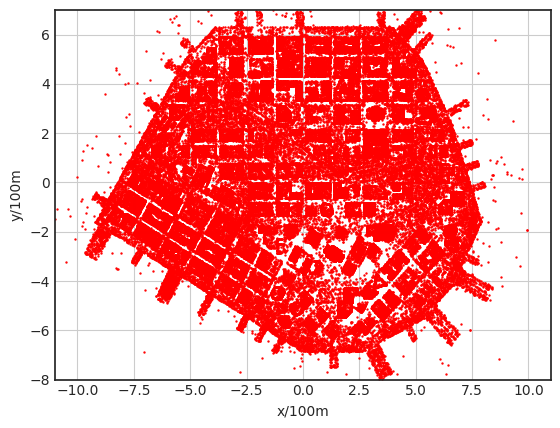

In [7]:
plt.figure()
plt.style.use('seaborn-white')
plt.scatter(xyz_org[::200, 0].detach().cpu(), xyz_org[::200, 1].detach().cpu(), s=0.5, c='r')
plt.xlim(-11, 11)
plt.ylim(-8, 7)
plt.xlabel('x/100m')
plt.ylabel('y/100m')
# plt.plot([xy_range[0], xy_range[0]], [xy_range[1], xy_range[3]], 'b')
# plt.plot([xy_range[2], xy_range[2]], [xy_range[1], xy_range[3]], 'b')
# plt.plot([xy_range[0], xy_range[2]], [xy_range[1], xy_range[1]], 'b')
# plt.plot([xy_range[0], xy_range[2]], [xy_range[3], xy_range[3]], 'b')
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


render time: 0.028949260711669922s


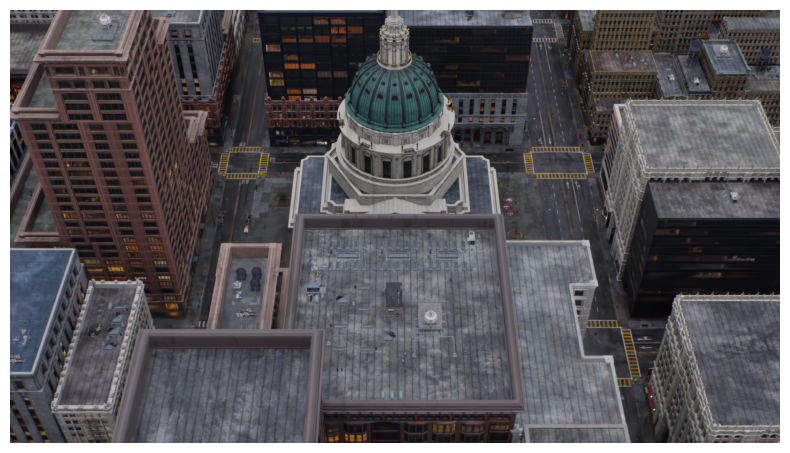

In [58]:
with torch.no_grad():
    # range free for block 9
    # interplay: 1517, 1114, 1538, 884, 849, 1535, 1532, 1264, 106, 99, 55
    # low quality: 1148, 916, 1560, 907

    # range free for block all
    # interplay: 
    # low quality: 101
    idx = random.randint(0, len(gs_dataset)-1)
    idx = 4700  # 4333, 4700

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    gaussians._features_dc = org_color

    mask = (xyz_org[:, 0] < 3.56) & (xyz_org[:, 0] > 2.82) & (xyz_org[:, 1] < 3.08) & (xyz_org[:, 1] > 2.5) & (xyz_org[:, 2] > 0.65) & (xyz_org[:, 2] < 0.82)
    gaussians._features_dc[mask] = gaussians._features_dc[mask][..., [1, 0, 2]]

    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    start = time.time()
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"]

    image = image.cpu().numpy().transpose(1,2,0)

    # show render results
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    # plt.title(f"Idx {idx}, Image {image_name}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

    # show visible points
    # plt.figure()
    # plt.style.use('seaborn-white')
    # visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
    # plt.scatter(xyz_org[::50, 0].detach().cpu(), xyz_org[::50, 1].detach().cpu(), s=0.5, c='r', label='orginal')
    # plt.scatter(xyz_org[visibility_filter][::50, 0].detach().cpu(), xyz_org[visibility_filter][::50, 1].detach().cpu(), s=0.5, c='g', label='visible')
    # plt.xlim(2.75, 3.6)
    # plt.ylim(2.5, 3.1)
    # # plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
    # # plt.yticks(np.linspace(0,1,block_dim[1]+1,endpoint=True))
    # plt.legend()
    # plt.grid(True)
    # plt.show()

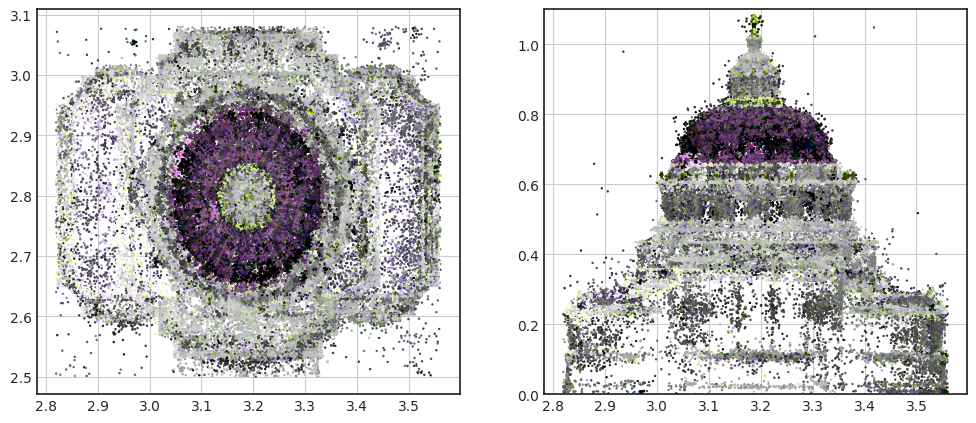

In [60]:
mask = (xyz_org[:, 0] < 3.56) & (xyz_org[:, 0] > 2.82) & (xyz_org[:, 1] < 3.08) & (xyz_org[:, 1] > 2.5) & (xyz_org[:, 2] > 0) & (xyz_org[:, 2] < 1.1)
target_xyz = xyz_org[mask]
target_color = torch.clamp(SH2RGB(gaussians.get_features[mask, 0, :]), 0, 1)
# permute red and green
target_color = target_color[:, [1, 0, 2]]

plt.figure(figsize=(12, 5))
plt.tight_layout()
plt.style.use('seaborn-white')

plt.subplot(1, 2, 1)
plt.scatter(target_xyz[:, 0].detach().cpu(), target_xyz[:, 1].detach().cpu(), s=0.5, c=target_color.detach().cpu())
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(target_xyz[:, 0].detach().cpu(), target_xyz[:, 2].detach().cpu(), s=0.5, c=target_color.detach().cpu())
plt.ylim(0, 1.1)
plt.grid(True)

## 2. Replacement

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


render time: 0.06739568710327148s


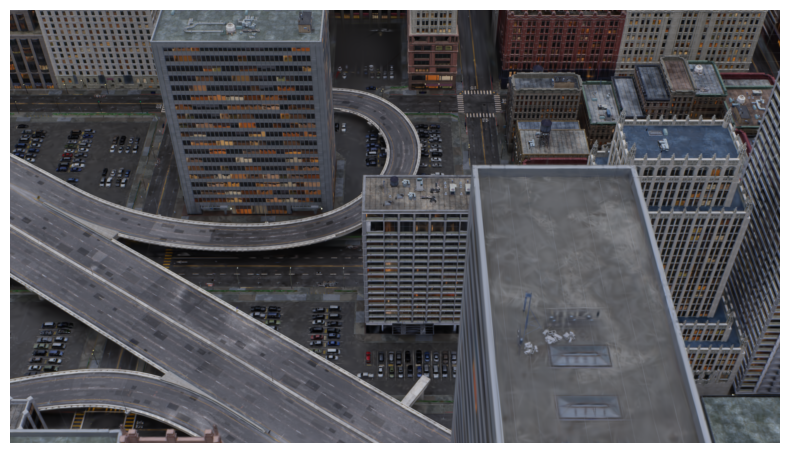

/home/yang_liu/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


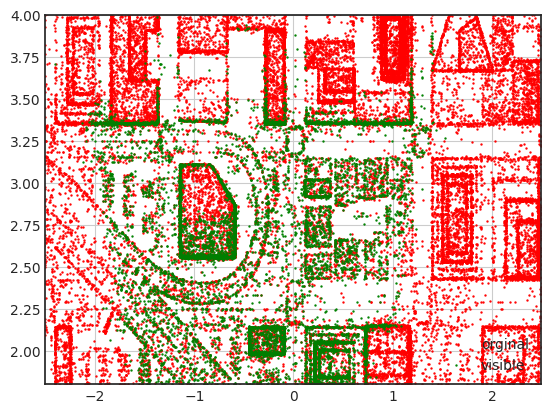

In [67]:
with torch.no_grad():

    idx = random.randint(0, len(gs_dataset)-1)
    idx = 4602  # 4333, 4700

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    start = time.time()
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"]

    image = image.cpu().numpy().transpose(1,2,0)

    # show render results
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    # plt.title(f"Idx {idx}, Image {image_name}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

    # show visible points
    plt.figure()
    plt.style.use('seaborn-white')
    visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
    plt.scatter(xyz_org[::200, 0].detach().cpu(), xyz_org[::200, 1].detach().cpu(), s=0.5, c='r', label='orginal')
    plt.scatter(xyz_org[visibility_filter][::200, 0].detach().cpu(), xyz_org[visibility_filter][::200, 1].detach().cpu(), s=0.5, c='g', label='visible')
    plt.xlim(-2.5, 2.5)
    plt.ylim(1.8, 4)
    plt.legend()
    plt.grid(True)
    plt.show()

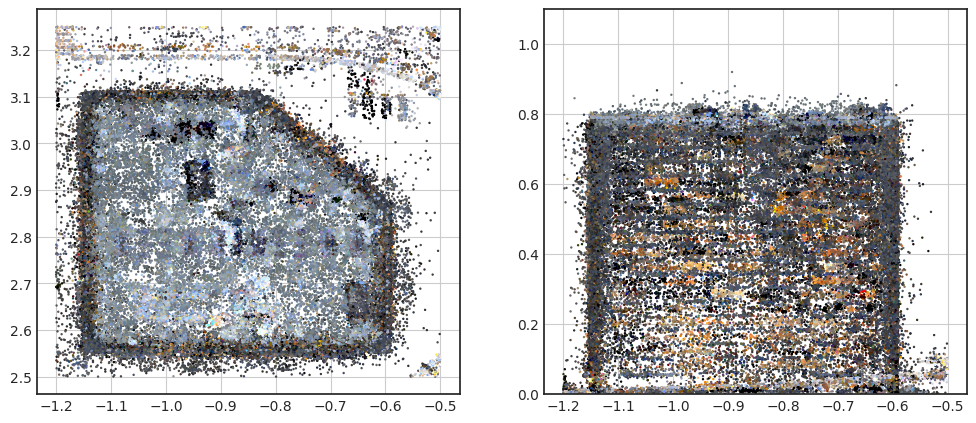

In [68]:
mask = (xyz_org[:, 0] < -0.5) & (xyz_org[:, 0] > -1.2) & (xyz_org[:, 1] < 3.25) & (xyz_org[:, 1] > 2.5)
target_xyz = xyz_org[mask]
target_color = torch.clamp(SH2RGB(gaussians.get_features[mask, 0, :]), 0, 1)
# permute red and green
# target_color = target_color[:, [1, 0, 2]]

plt.figure(figsize=(12, 5))
plt.tight_layout()
plt.style.use('seaborn-white')

plt.subplot(1, 2, 1)
plt.scatter(target_xyz[:, 0].detach().cpu(), target_xyz[:, 1].detach().cpu(), s=0.5, c=target_color.detach().cpu())
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(target_xyz[:, 0].detach().cpu(), target_xyz[:, 2].detach().cpu(), s=0.5, c=target_color.detach().cpu())
plt.ylim(0, 1.1)
plt.grid(True)